# Symetric neuron - Response delay
Here, we investigate the intrinsic computation delay due to the chemical kinetics of such a neuron.

We have the system of equation for a and b, and the output of a neuron is defined as the steady state fraction of a*
$$out=\frac{a*}{a*+b*}$$

$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$

Where:
- $a, b$: dynamic variables (e.g., population levels, concentrations)
- $P, N$: external input/production rates
- $\lambda_a, \lambda_b$: growth rate constants
- $k_a, k_b$: saturation constants (Hill-type terms)
- $\eta_a, \eta_b$: decay or dilution rates
- $\mu_a, \mu_b$: interaction strengths between $a$ and $b$

We firsty considers noise over N and P.

### Equation of the decision boundary

Considering $x(t)=a-b$, the concentration difference, one can recast the previous system into the following form 
$$\dot{x}=\dot{a}-{b}=[P-N]+\frac{\lambda_a a}{1+k_a a}-\frac{\lambda_b b}{1+k_b b} -\eta_a a+\eta_b b -(\mu_a-\mu_b)ab$$

As one want the fixed point equation for $(a^*,b^*)$ then $\dot{x}=0$. So as to recover the frontier, the previous equation must satisfy $a^*=b^*$. This yelds to the frontier equation i.e. the ensemble {$(P,N)/a^*=b^*$ according to the fp equation}
$$P=N+(\frac{\lambda_b}{1+k_b a^*}-\frac{\lambda_a}{1+k_a a^*})a^*-(\eta_b-\eta_a)a^*+(\mu_a-\mu_b)a^{*2}$$

## 1. Symmetrical system

By symmetrical, we mean that all constants $$ \begin{aligned} \eta_a = \eta_b &= 0.1 \\ \mu_a =\mu_b &= 0.2 \\ k_a = k_b &= 0.7 \\ \lambda_a = \lambda_b &= 1.0 \end{aligned} $$  are equal for a and b. Therefore, the frontier equation is just 
$$P=N$$



The threshold of a neuron is determined by the bias terms \( a_0 \) and \( b_0 \), which correspond to the initial concentrations of \( a \) and \( b \). These biases effectively shift the decision boundary. 

In such a case, the decision boundary takes the form:
$$
P = N + f(a_0, b_0)
$$


### 1.1 Dynamics and binary classification

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from matplotlib.collections import LineCollection
from tqdm.notebook import tqdm
from itertools import product


This plot shows the neuron's classification with respect to the input sums $P$ and $N$. Initial concentrations  
$a_0 \quad \text{and} \quad b_0$
can be introduced as biases, effectively shifting the decision boundary.

The working range limit, defined by 
$P, N < 1.25,$
is indicated in orange. This threshold depends on the parameters 
$\mu_a \quad \text{and} \quad \mu_b,$
and the plotted case corresponds to 
$\mu_a = \mu_b = 0.2.$


In [50]:
# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2
k_a = 0.7
k_b = 0.7
lambda_a = 1.0
lambda_b = 1.0
alpha_bias= 0.0
beta_bias = 0.0

# --- Parameter grid for numerical integration ---
xlimit=3.0
ylimit=3.0
nb_of_points = 50
P_grid = np.linspace(0.0, ylimit, nb_of_points)  # P entre 0 et 1.25
N_grid = np.linspace(0.0, xlimit, nb_of_points)  # N entre 0 et 1.25

# Noise parameters
noise_sigma = 0.6  # écart-type du bruit gaussien ajouté

# Time span and initial condition for the ODE
t_span_full = (0, 150)
y0 = [alpha_bias, beta_bias]  # Conditions initiales pour a et b

In [51]:
# --- System equations ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# Integration helper function
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]  # Valeurs finales de a et b

# --- Generate data with noise ---
results = []  # stockage des résultats (P bruité, N bruité, a, b)

for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points*nb_of_points):
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))  # P bruité, positif
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))  # N bruité, positif
    
    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    
    # Clamp les valeurs pour la visualisation
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]



  0%|          | 0/2500 [00:00<?, ?it/s]

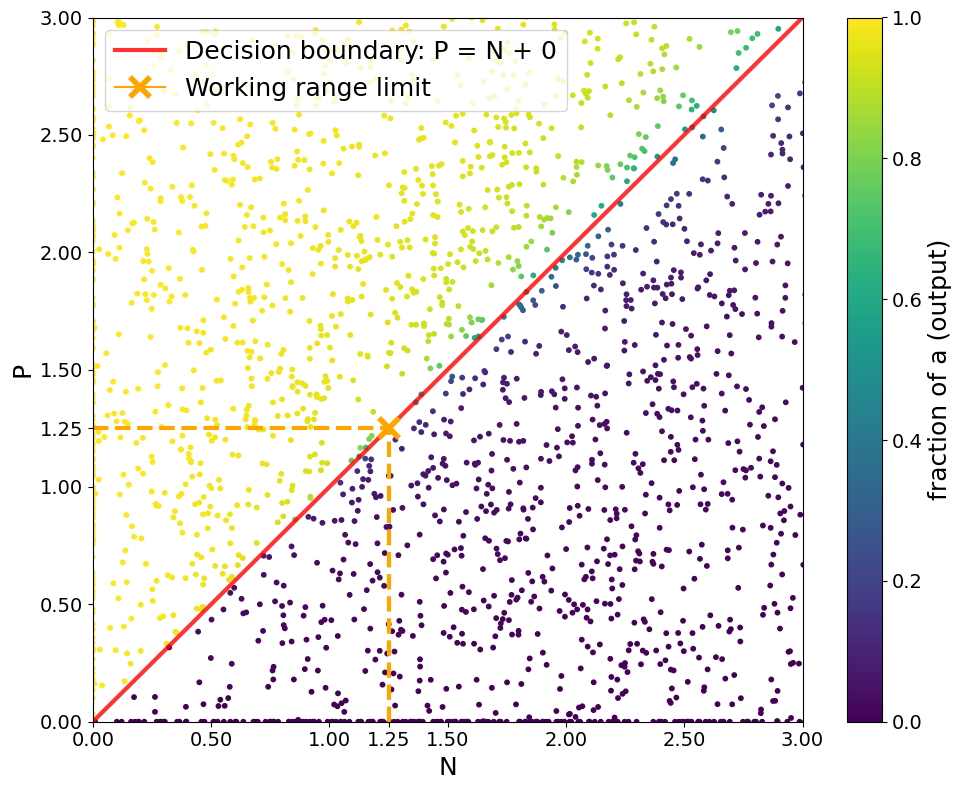

In [52]:
# --- Plot the phase diagram ---
fig, ax = plt.subplots(figsize=(10, 8))

a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)

sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_xlabel("N", fontsize=18)
ax.set_ylabel("P", fontsize=18)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("fraction of a (output)", fontsize=18)
cbar.ax.tick_params(labelsize=14)

biais=0
# Tracé d'une fonction personnalisée : P = f(N)
N_vals = np.linspace(0, xlimit, 300)
P_vals = N_vals + biais  # Par exemple une droite avec un biais

ax.plot(N_vals, P_vals, color='red', alpha=0.8, linewidth=3, label=f'Decision boundary: P = N + {biais}')


# Tracé des traits pointillés partant de (1.25,1.25) jusqu'aux axes
x_cross, y_cross = 1.25, 1.25
ax.plot([x_cross, x_cross], [0, y_cross], color='orange', linestyle='--', linewidth=3)
ax.plot([0, x_cross], [y_cross, y_cross], color='orange', linestyle='--', linewidth=3)
ax.plot(x_cross, y_cross, marker='x', color='orange', markersize=15, mew=4, label='Working range limit')

# Limiter les axes entre 0 et 3
ax.set_xlim(0, xlimit)
ax.set_ylim(0, ylimit)

# Ajouter la graduation 1.25 sur les axes
xticks = list(ax.get_xticks()) + [1.25]
yticks = list(ax.get_yticks()) + [1.25]
ax.set_xticks(sorted(set(xticks)))
ax.set_yticks(sorted(set(yticks)))

# Augmenter la taille des ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Légende en haut à gauche
ax.legend(fontsize=18, loc='upper left')

plt.tight_layout()
plt.show()





There is an important point to consider : a condition for the bistability is that $P,N<1.25$. Going behond the working range leads to more and more neuron to be in the undecided state (gree zone), because the undecided FP is a stable one.

Up to this point, we have considered a fully symmetric version of the system, with symmetric parameters 
$$
\lambda, \eta, \mu.
$$

The system consistently exhibits bistable switching behavior. The closer the initial values of \( P \) and \( N \) are to each other, the longer it takes to reach the final polarized state (i.e., a 0–100 concentration distribution). 

In the special case where 
$$
P = N,
$$ 
the convergence time becomes infinite, and both species stabilize at equal concentrations, resulting in a 50/50 distribution of \( a \) and \( b \) (as shown in the first graph).

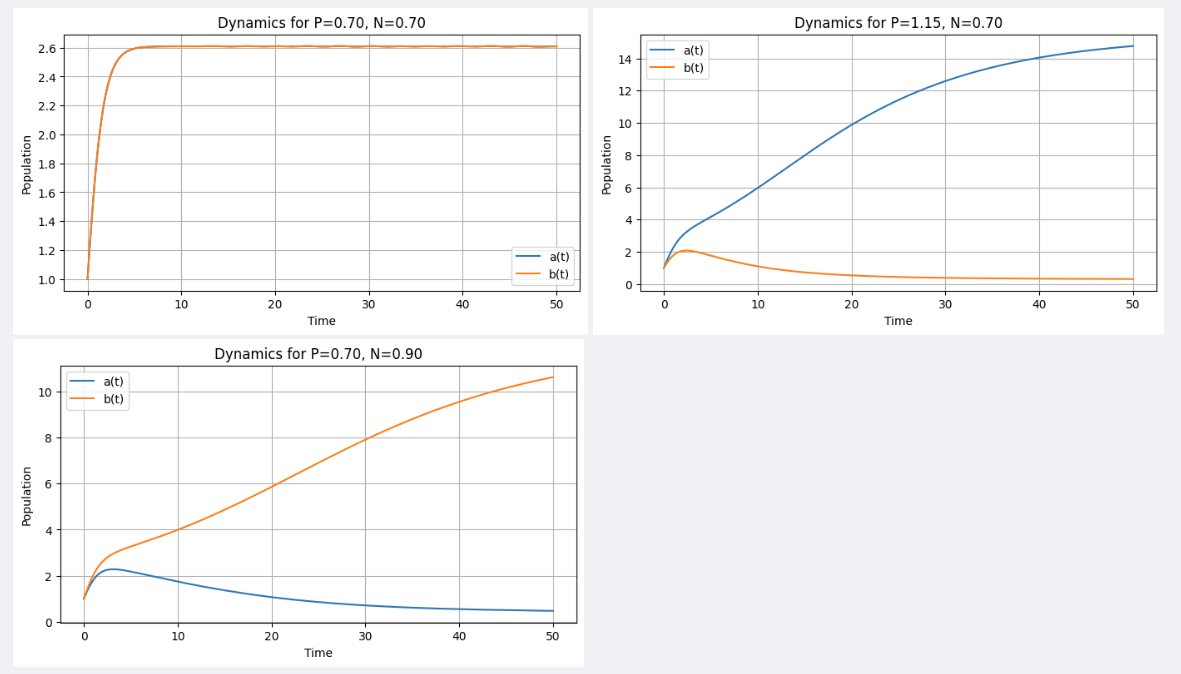

This outcome is expected: the greater the difference between \( P \) and \( N \) (i.e., the farther from the diagonal \( P = N \)), the faster one species dominates the other. In contrast, at 
$$
P = N,
$$ 
the system remains balanced indefinitely.


### 1.2 Profile and roughness of the boundary with respect to the computation time 

We want to probe what happen for the classification performance if the maturation of a neuron is stopped before having reached a steady state. 

In [53]:

# --- System parameters ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b   = 0.2, 0.2
k_a, k_b     = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

num_points = 200

# --- Noise & integration setup ---
noise_sigma = 0.1
y0 = [1e-6, 1e-6]

# --- Final times to compare transient vs steady ---
tf_list = [10,100,1000]

# Set desired plot ranges here:
x_min, x_max = 5, 12.5
y_min_plot, y_max_plot = 0, 1.05


In [54]:
# --- Simulation ---
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0, args=(P, N),
                    t_eval=t_eval, method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- Parameterize anti-diagonal from (N=0, P=10) to (N=10, P=0) ---

t_line = np.linspace(0, 1, num_points)
N_diag = 10 * t_line
P_diag = 10 * (1 - t_line)
distance_diag = 10 * np.sqrt(2) * t_line



# --- Compute percentage-of-a profiles ---
profiles = {}
for tf in tqdm(tf_list, desc="Processing tf values"):
    profile = np.zeros(num_points)
    for i in range(num_points):
        noisy_N = max(0, N_diag[i] + np.random.normal(scale=noise_sigma))
        noisy_P = max(0, P_diag[i] + np.random.normal(scale=noise_sigma))
        a_f, b_f = integrate_ode(noisy_P, noisy_N, y0, (0, tf))
        profile[i] = np.clip(a_f / (a_f + b_f + 1e-10), 0, 1)
    profiles[tf] = profile

# --- Prepare colormap ---
all_vals = np.concatenate(list(profiles.values()))
norm = plt.Normalize(vmin=all_vals.min(), vmax=all_vals.max())
cmap = plt.cm.viridis

# --- Compute where N = P on the anti-diagonal ---
idx_eq = np.argmin(np.abs(N_diag - P_diag))
distance_eq = distance_diag[idx_eq]



Processing tf values:   0%|          | 0/3 [00:00<?, ?it/s]

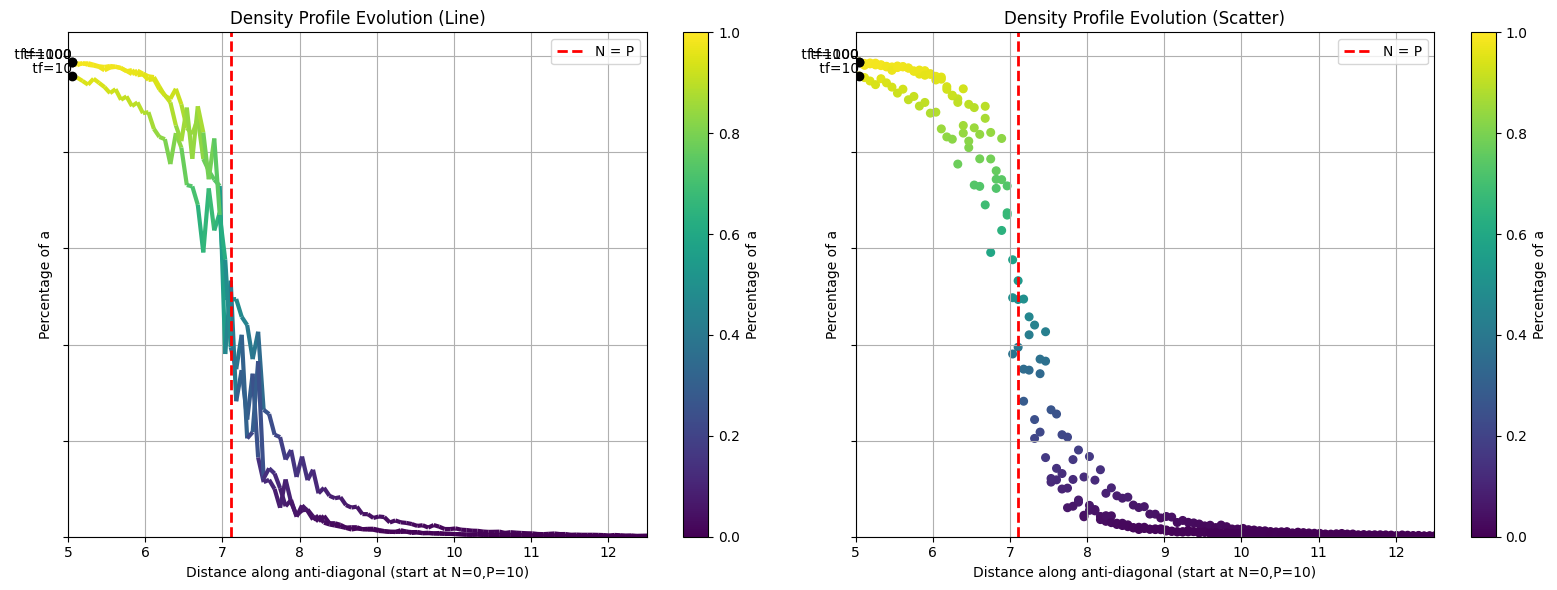

In [55]:
# --- Plotting ---

# Find an index for annotation in the visible window
annotate_index = np.where((distance_diag >= x_min) & (distance_diag <= x_max))[0][0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Line plot with colored segments
for tf, profile in profiles.items():
    points   = np.vstack([distance_diag, profile]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    seg_colors = [(cmap(norm((profile[i] + profile[i+1]) / 2))) for i in range(len(profile)-1)]
    lc = LineCollection(segments, colors=seg_colors, linewidths=3)
    ax1.add_collection(lc)
    # annotate at the first visible point
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax1.plot(d0, p0, 'ko')
    ax1.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax1.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min_plot, y_max_plot)
ax1.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax1.set_ylabel("Percentage of a")
ax1.set_title("Density Profile Evolution (Line)")
ax1.grid(True)
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm1.set_array([])
plt.colorbar(sm1, ax=ax1, label="Percentage of a")
ax1.legend()

# Remove y-axis tick labels
ax1.set_yticklabels([])

# Scatter plot
for tf, profile in profiles.items():
    ax2.scatter(distance_diag, profile, c=profile, cmap=cmap, norm=norm, s=30)
    d0 = distance_diag[annotate_index]
    p0 = profile[annotate_index]
    ax2.plot(d0, p0, 'ko')
    ax2.text(d0, p0, f' tf={tf}', va='bottom', ha='right')

# Add the N = P frontier line
ax2.axvline(distance_eq, color='red', linestyle='--', linewidth=2, label='N = P')

ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min_plot, y_max_plot)
ax2.set_xlabel("Distance along anti-diagonal (start at N=0,P=10)")
ax2.set_ylabel("Percentage of a")
ax2.set_title("Density Profile Evolution (Scatter)")
ax2.grid(True)
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])
plt.colorbar(sm2, ax=ax2, label="Percentage of a")
ax2.legend()

# Remove y-axis tick labels
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()




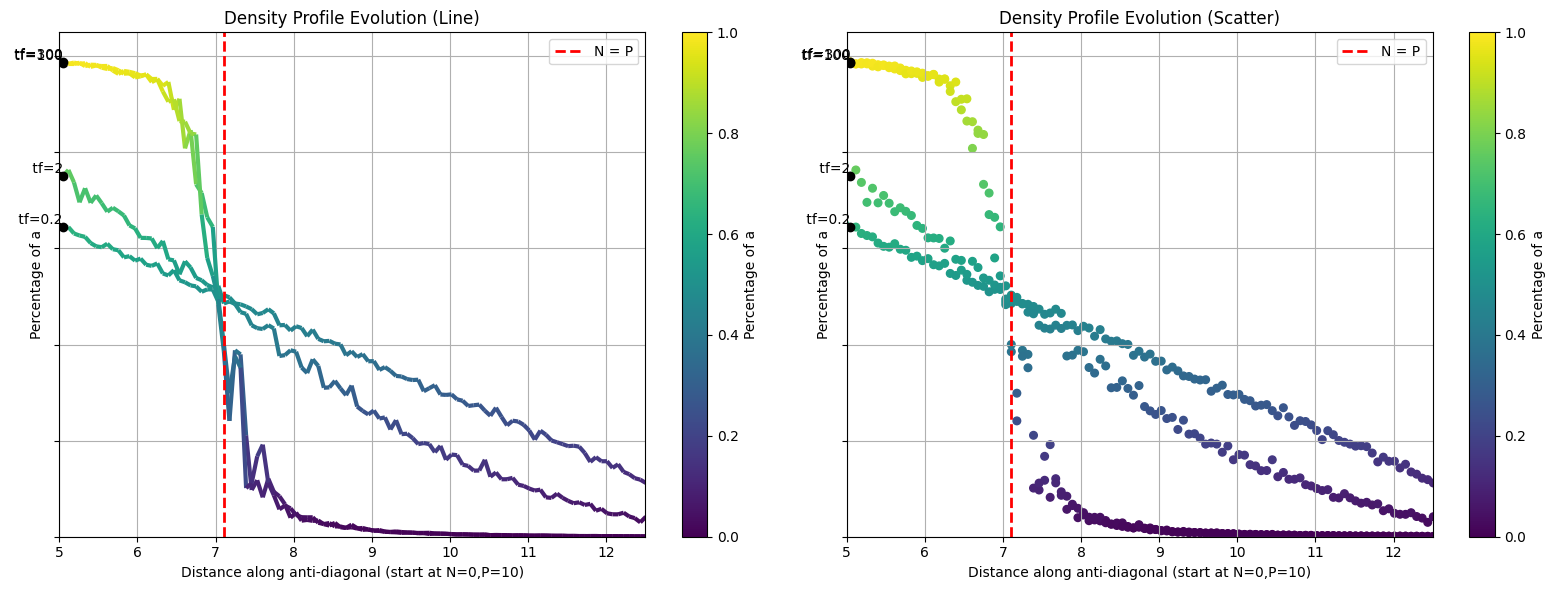

We can see that early stopping freezes most of the neurons in an undecided state. The greater the noise, the more likely it is to find false positives near the decision boundary, i.e., errors. There is no significant difference between $t_f = 300$ and $t_f = 1000$.


### 1.3 Convergence time and working range dependency 
We would like to see how long it takes for a neuron to converge toward its steady state depending on the input values $P$ and $N$. To do so, we plot the output dynamics $\frac{a^*}{a^* + b^*}$ of a neuron for different values of $P, N < 1.25$ within the working range.


In [56]:
# --- Noise and grid setup ---
noise_sigma = 0.2
nb_of_points_grid = 40
P_values = np.linspace(0, 1.25, nb_of_points_grid)
N_values = np.linspace(0, 1.25, nb_of_points_grid)
all_points = [(P, N) for P in P_values for N in N_values]

# --- Time span for single tf ---
tf_single     = 1000
t_eval_single = np.linspace(0, tf_single, 500)

Integrating percentage of a(t):   0%|          | 0/1600 [00:00<?, ?it/s]

Percentage of neurons with final a‐percentage within ±5.0% of 50%: 0.38%


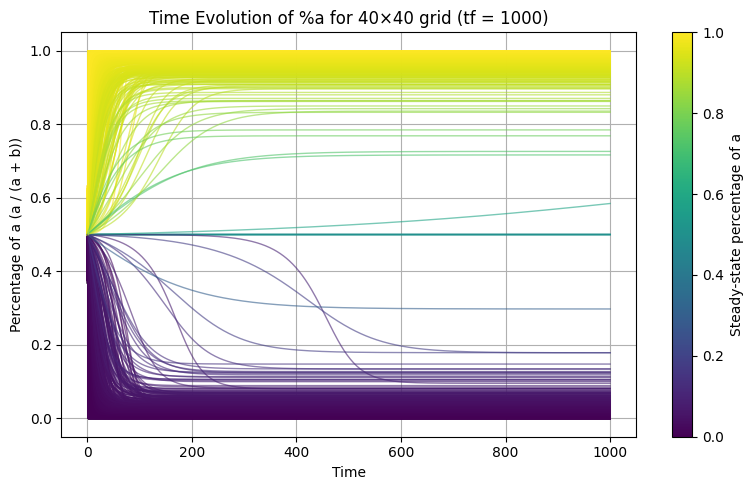

In [57]:
# --- ODE system ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Integration helper ---
def integrate_system(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.t, sol.y[0], sol.y[1]  # times, a(t), b(t)



# --- Colormap for percentage of a ---
cmap_y = plt.cm.viridis
norm_y = plt.Normalize(vmin=0.0, vmax=1.0)

# --- Tolerance around 50% for counting neurons ---
tol = 0.05  # i.e. count those with |pct_a - 0.5| < 0.05

# --- Plotting setup ---
fig, ax = plt.subplots(figsize=(8, 5))

# we'll collect final percentages to compute the counter
final_pcts = []

for P0, N0 in tqdm(all_points, desc="Integrating percentage of a(t)"):
    # add Gaussian noise to inputs
    noisy_P = max(0, P0 + np.random.normal(scale=noise_sigma))
    noisy_N = max(0, N0 + np.random.normal(scale=noise_sigma))
    
    # integrate up to tf_single
    t, a_t, b_t = integrate_system(noisy_P, noisy_N, 
                                   y0=[1e-6, 1e-6], 
                                   t_span=(0, tf_single),
                                   t_eval=t_eval_single)
    # compute percentage of a
    pct_a = a_t / (a_t + b_t + 1e-10)
    
    # store final percentage
    final_pcts.append(pct_a[-1])
    
    # pick color by final percentage
    color = cmap_y(norm_y(pct_a[-1]))
    
    # plot percentage vs time
    ax.plot(t, pct_a, color=color, lw=1, alpha=0.6)

# compute how many are approximately at 50%
final_pcts = np.array(final_pcts)
mask_50 = np.abs(final_pcts - 0.5) < tol
percent_50 = mask_50.sum() / mask_50.size * 100

# display the result
print(f"Percentage of neurons with final a‐percentage within ±{tol*100:.1f}% of 50%: {percent_50:.2f}%")

# labels and colorbar
ax.set_xlabel("Time")
ax.set_ylabel("Percentage of a (a / (a + b))")
ax.set_title(f"Time Evolution of %a for {nb_of_points_grid}×{nb_of_points_grid} grid (tf = {tf_single})")
ax.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap_y, norm=norm_y)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Steady‐state percentage of a")

plt.tight_layout()
plt.show()



Within the working range, most neurons end up in the decided state $a$ or $b$ because the two stable fixed points correspond to either on or off. The only remaining undecided neurons (less than 1%) correspond to the 50/50 green curves, whose state is balanced at 50/50 because the initial condition was exactly $P = N$.  

We can investigate what happens when we run the classification with input values outside the working range (see below). In such situations, there is only one fixed point, which can be either $a$, $b$, or undecided. Consequently, when a neuron starts with inputs inside the basin of attraction of $P = N$, it will converge toward the undecided state. This is problematic, as we lose a lot of information:




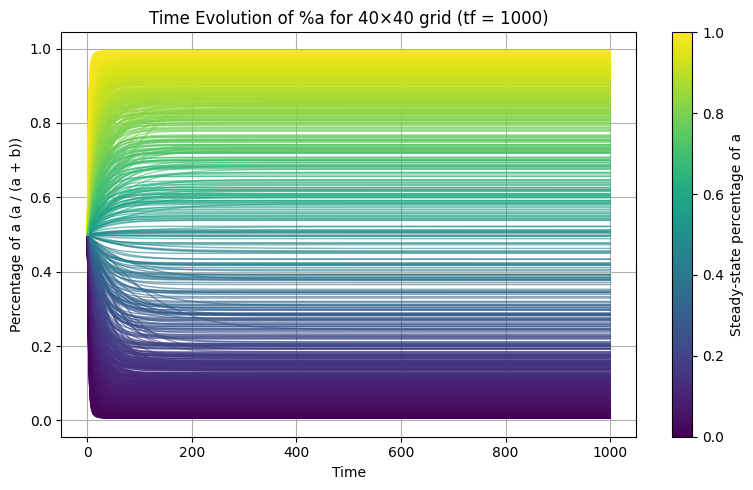

We can then try to see how long it would takes for the entier set of neuron to reach a steady state. 

In [58]:
# --- System parameters ---
eta_a, eta_b       = 0.1, 0.1
mu_a,  mu_b        = 0.2, 0.2
k_a,   k_b         = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- Noise parameters ---
noise_sigma = 0.2  # standard deviation of Gaussian noise on inputs

# --- Integration parameters ---
tf_single      = 1000
t_eval_single  = np.linspace(0, tf_single, 500)

# --- Grid of neurons (P, N values) ---
nb_of_points_grid = 20
P_values          = np.linspace(0, 1.25, nb_of_points_grid)
N_values          = np.linspace(0, 1.25, nb_of_points_grid)
all_neurons       = [(P, N) for P in P_values for N in N_values]

# --- Convergence criterion parameters ---
tol_rate = 1e-3   # threshold on |dp/dt|
M        = 50     # number of consecutive points below threshold
# --- Plotting range (user-defined) ---
plot_t_min = 0     # e.g. 0
plot_t_max = 1000    # e.g. 50 (must be <= tf_single)

Computing convergence times for grid with 400 neurons...


Integrating neurons:   0%|          | 0/400 [00:00<?, ?it/s]

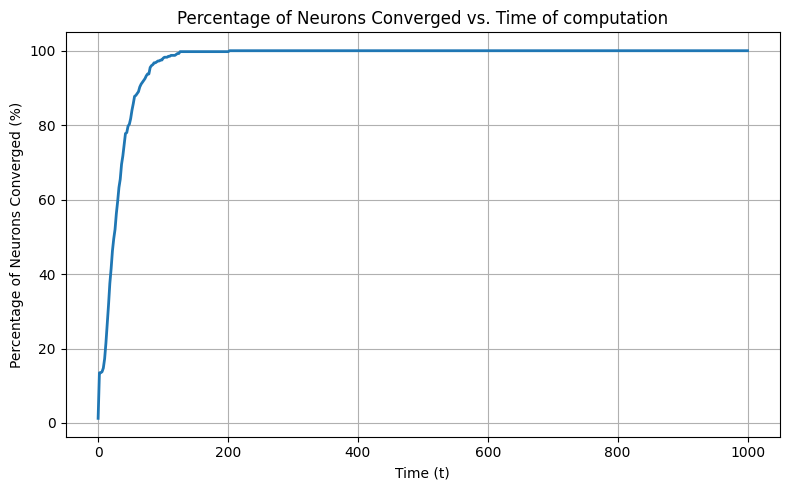

In [59]:
# --- Simulation ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Convergence time storage ---
convergence_times = []

print(f"Computing convergence times for grid with {nb_of_points_grid**2} neurons...")
for P0, N0 in tqdm(all_neurons, desc="Integrating neurons"):
    # Add Gaussian white noise and clip to non-negative
    noisy_P = max(P0 + np.random.normal(scale=noise_sigma), 0)
    noisy_N = max(N0 + np.random.normal(scale=noise_sigma), 0)

    # Integrate the system
    sol = solve_ivp(system, (0, tf_single), [1e-6, 1e-6],
                    args=(noisy_P, noisy_N),
                    t_eval=t_eval_single,
                    method="RK45", rtol=1e-8, atol=1e-10)

    a_vals, b_vals = sol.y
    pct_a_vals = a_vals / (a_vals + b_vals + 1e-10)  # percentage of a
    t_vals     = sol.t

    # approximate dp/dt by finite differences
    dt   = t_vals[1] - t_vals[0]
    dpdt = np.diff(pct_a_vals) / dt

    # find first time where |dp/dt| < tol_rate for M consecutive points
    conv_time = tf_single
    for i in range(len(dpdt) - M):
        if np.all(np.abs(dpdt[i:i+M]) < tol_rate):
            conv_time = t_vals[i]
            break

    convergence_times.append(conv_time)

convergence_times = np.array(convergence_times)

# --- Compute percentage of neurons converged over time ---
time_grid = np.linspace(0, tf_single, 500)
percentage_converged = [
    100 * np.sum(convergence_times <= t) / convergence_times.size
    for t in time_grid
]

# --- Plot ---
# Mask time and percentage arrays based on plotting range
mask = (time_grid >= plot_t_min) & (time_grid <= plot_t_max)
time_to_plot = time_grid[mask]
percentage_to_plot = np.array(percentage_converged)[mask]


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_to_plot, percentage_to_plot, lw=2)
ax.set_xlabel("Time (t)")
ax.set_ylabel("Percentage of Neurons Converged (%)")
ax.set_title(f"Percentage of Neurons Converged vs. Time of computation")
ax.grid(True)
plt.tight_layout()
plt.show()


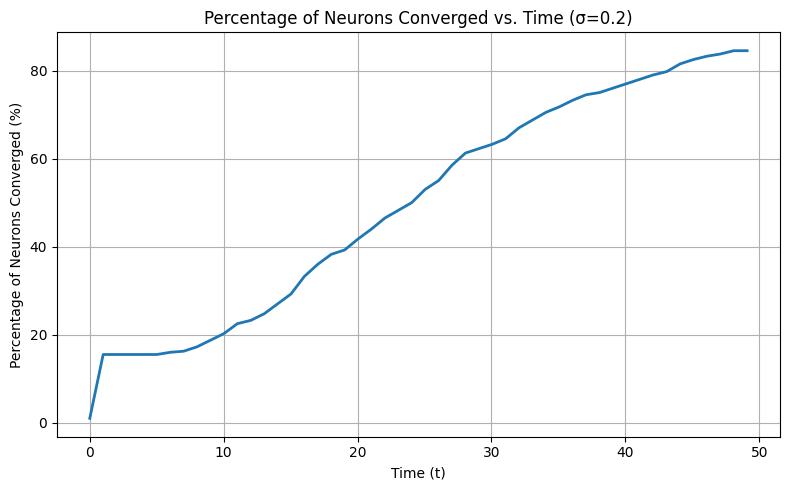

The initial Winner-Takes-All (WTA) separation between the two curves occurs rapidly. As a result, neurons that started with very different initial concentrations of \( P \) and \( N \) tend to converge quickly. 
It is possible that the second plateau reflects the typical convergence time for the majority of neurons, whose initial states lie neither too close nor too far from the respective basins of attraction. In contrast, neurons that take significantly longer to converge may originate from regions very close to the line \( P = N \), where the dynamical separation is weakest.
This behavior warrants further investigation.

### 1.4 Decision time 
We should expect a power law for the time to converge toward a *decided state* depending on the initial concentration P and N, ie the position in the configurational space  $$t_f\propto|P-N|^{-\alpha}$$

The objective is to compute the **characteristic time** required for a neuron to reach a **decided state**, defined by the following two criteria:

1. **Stationarity**:  
   The derivatives of \( a(t) \) and \( b(t) \) remain small over a certain number of consecutive time points. Specifically, we require:
   $$
   \Bigl|\dot a(t)\Bigr| < \varepsilon_{\rm stat}
   \quad\text{and}\quad
   \Bigl|\dot b(t)\Bigr| < \varepsilon_{\rm stat}
   $$
   for \( M \) consecutive time steps.

2. **Asymmetry**:  
   The final concentrations of \( a \) and \( b \) must differ significantly, meaning:
   $$
   \bigl|\,a(t) - b(t)\bigr| > \varepsilon_{\rm diff}
   $$
   over the same window of \( M \) time steps.


In [ ]:
# --- Paramètres dynamiques ---
eta_a, eta_b = 0.1, 0.1
mu_a, mu_b = 0.2, 0.2
k_a, k_b = 0.7, 0.7
lambda_a, lambda_b = 1.0, 1.0

# --- Paramètres de simulation ---
tf = 1000
t_eval = np.linspace(0, tf, 3000)
dt = t_eval[1] - t_eval[0]

# --- Balayage gaussien autour de P = N ---
P_center, N_center = 1.0,1.0
num_samples = 500
delta_range = np.random.normal(loc=0.0, scale=0.1, size=num_samples)
noise_sigma = 0.02

# --- Seuils de décision ---
tol_stationary = 1e-4
tol_difference = 1e-2
M = 10

In [75]:
# --- Simulation des ODEs ---
# --- ODEs ---
def da_dt(a, b, P):
    return P + (lambda_a * a)/(1 + k_a*a) - eta_a*a - mu_a*a*b

def db_dt(a, b, N):
    return N + (lambda_b * b)/(1 + k_b*b) - eta_b*b - mu_b*a*b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]


# --- Stockage ---
delta_PN_list = []
decision_times = []

# --- Simulation ---
for delta in tqdm(delta_range, desc="Simulation"):
    P = P_center + delta / 2
    N = N_center - delta / 2
    P_noisy = max(P + np.random.normal(scale=noise_sigma), 0)
    N_noisy = max(N + np.random.normal(scale=noise_sigma), 0)
    delta_PN = P_noisy - N_noisy

    sol = solve_ivp(system, (0, tf), [1e-6, 1e-6],
                    args=(P_noisy, N_noisy),
                    t_eval=t_eval, method="RK45", rtol=1e-8, atol=1e-10)
    a, b = sol.y
    t = sol.t

    da = np.diff(a) / dt
    db = np.diff(b) / dt
    diff_ab = np.abs(a - b)

    t_decided = np.inf
    for i in range(len(da) - M):
        if (np.all(np.abs(da[i:i+M]) < tol_stationary) and
            np.all(np.abs(db[i:i+M]) < tol_stationary) and
            np.all(diff_ab[i:i+M] > tol_difference)):
            t_decided = t[i]
            break

    delta_PN_list.append(delta_PN)
    decision_times.append(t_decided)

# --- Analyse ---
delta_PN_arr = np.array(delta_PN_list)
decision_times_arr = np.array(decision_times)
mask = np.isfinite(decision_times_arr)
dPN = delta_PN_arr[mask]
tconv = decision_times_arr[mask]

# Séparation selon le signe
dPN_pos = dPN[dPN > 0]
t_pos = tconv[dPN > 0]
dPN_neg = -dPN[dPN < 0]  # on prend -delta pour le fit
t_neg = tconv[dPN < 0]

# --- Fit log-log ---
eps = 1e-6
mask_pos = dPN_pos > eps
mask_neg = dPN_neg > eps

log_dPN_pos = np.log(dPN_pos[mask_pos])
log_t_pos = np.log(t_pos[mask_pos])
slope_pos, intercept_pos = np.polyfit(log_dPN_pos, log_t_pos, 1)
k_pos = -slope_pos
C_pos = np.exp(intercept_pos)

log_dPN_neg = np.log(dPN_neg[mask_neg])
log_t_neg = np.log(t_neg[mask_neg])
slope_neg, intercept_neg = np.polyfit(log_dPN_neg, log_t_neg, 1)
k_neg = -slope_neg
C_neg = np.exp(intercept_neg)



Simulation:   0%|          | 0/500 [00:00<?, ?it/s]

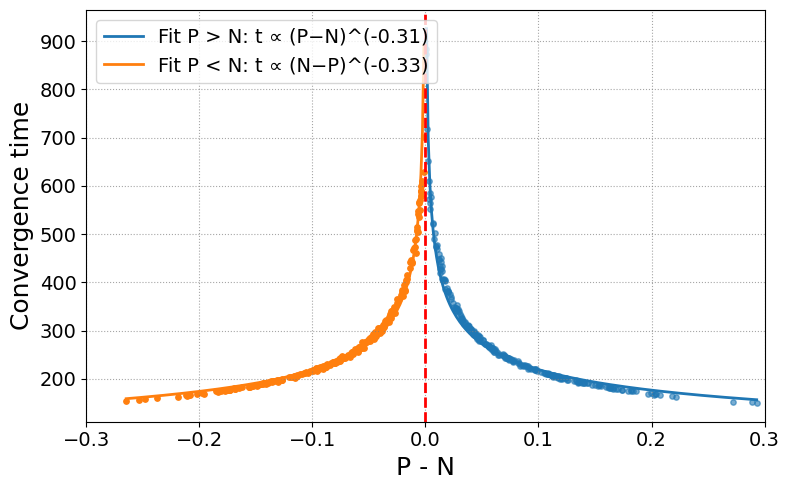

In [76]:
# --- Affichage des résultats ---
# Définir l’intervalle symétrique autour de zéro (exemple L=0.5, adapte selon ton besoin)
L = 0.3

# --- Filtrer les données pour ne garder que celles dans [-L, L] ---
mask_pos_interval = (dPN_pos <= L) & (dPN_pos >= 0)
mask_neg_interval = (dPN_neg <= L) & (dPN_neg >= 0)

dPN_pos_filtered = dPN_pos[mask_pos_interval]
t_pos_filtered = t_pos[mask_pos_interval]

dPN_neg_filtered = dPN_neg[mask_neg_interval]
t_neg_filtered = t_neg[mask_neg_interval]

# --- Tracé final en linéaire linéaire ---
fig, ax = plt.subplots(figsize=(8, 5))

# Scatter filtré (avec labels si tu veux légende)
ax.scatter(dPN_pos_filtered, t_pos_filtered, color='C0', s=15, alpha=0.6)
ax.scatter(-dPN_neg_filtered, t_neg_filtered, color='C1', s=15)

# Domaines de fit dans l’intervalle défini
dPNp_model = np.linspace(max(dPN_pos_filtered.min(), 0.001), dPN_pos_filtered.max(), 200)
tpos_model = C_pos * dPNp_model**(-k_pos)

dPNn_model = np.linspace(max(dPN_neg_filtered.min(), 0.001), dPN_neg_filtered.max(), 200)
tneg_model = C_neg * dPNn_model**(-k_neg)

# Courbes de fit
ax.plot(dPNp_model, tpos_model, color='C0', lw=2,
         label=f'Fit P > N: t ∝ (P−N)^(-{k_pos:.2f})')
ax.plot(-dPNn_model, tneg_model, color='C1', lw=2,
         label=f'Fit P < N: t ∝ (N−P)^(-{k_neg:.2f})')

# Ligne verticale P=N
ax.axvline(0, color='red', ls='--', lw=2)

# Limites de l’axe x symétriques
ax.set_xlim(-L, L)

# Textes agrandis
ax.set_xlabel("P - N", fontsize=18)
ax.set_ylabel("Convergence time", fontsize=18)

# Agrandir ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Agrandir légende
ax.legend(fontsize=14, loc='upper left')

ax.grid(True, ls=':', color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

We observe a power-law relationship as a function of the distance to the boundary. However, the exponent $\alpha$ is not universal; it depends on the value of $P$ ($=N$). Consequently, one can compute $\alpha$ as a function of $P$ ($=N$) along the boundary.



In [63]:
# --- Exploration de alpha le long de P=N ---
# Liste des valeurs centrales de P=N à explorer
P_vals = np.linspace(0, 1.25, 30)  # adapte la plage et le nombre
alphas_pos = []
alphas_neg = []

for P_center in tqdm(P_vals, desc="Exploration P=N"):

    delta_range = np.random.normal(loc=0.0, scale=0.1, size=num_samples)

    delta_PN_list = []
    decision_times = []

    for delta in delta_range:
        P = P_center + delta / 2
        N = P_center - delta / 2
        P_noisy = max(P + np.random.normal(scale=noise_sigma), 0)
        N_noisy = max(N + np.random.normal(scale=noise_sigma), 0)
        delta_PN = P_noisy - N_noisy

        sol = solve_ivp(system, (0, tf), [1e-6, 1e-6],
                        args=(P_noisy, N_noisy),
                        t_eval=t_eval, method="RK45", rtol=1e-8, atol=1e-10)
        a, b = sol.y
        t = sol.t

        da = np.diff(a) / dt
        db = np.diff(b) / dt
        diff_ab = np.abs(a - b)

        t_decided = np.inf
        for i in range(len(da) - M):
            if (np.all(np.abs(da[i:i+M]) < tol_stationary) and
                np.all(np.abs(db[i:i+M]) < tol_stationary) and
                np.all(diff_ab[i:i+M] > tol_difference)):
                t_decided = t[i]
                break

        delta_PN_list.append(delta_PN)
        decision_times.append(t_decided)

    # Analyse pour cette valeur de P_center
    delta_PN_arr = np.array(delta_PN_list)
    decision_times_arr = np.array(decision_times)
    mask = np.isfinite(decision_times_arr)
    dPN = delta_PN_arr[mask]
    tconv = decision_times_arr[mask]

    dPN_pos = dPN[dPN > 0]
    t_pos = tconv[dPN > 0]
    dPN_neg = -dPN[dPN < 0]
    t_neg = tconv[dPN < 0]

    # Fit log-log
    eps = 1e-4
    mask_pos = dPN_pos > eps
    mask_neg = dPN_neg > eps

    if np.sum(mask_pos) >= 5:
        log_dPN_pos = np.log(dPN_pos[mask_pos])
        log_t_pos = np.log(t_pos[mask_pos])
        slope_pos, _ = np.polyfit(log_dPN_pos, log_t_pos, 1)
        alphas_pos.append(-slope_pos)
    else:
        alphas_pos.append(np.nan)

    if np.sum(mask_neg) >= 5:
        log_dPN_neg = np.log(dPN_neg[mask_neg])
        log_t_neg = np.log(t_neg[mask_neg])
        slope_neg, _ = np.polyfit(log_dPN_neg, log_t_neg, 1)
        alphas_neg.append(-slope_neg)
    else:
        alphas_neg.append(np.nan)


Exploration P=N:   0%|          | 0/30 [00:00<?, ?it/s]

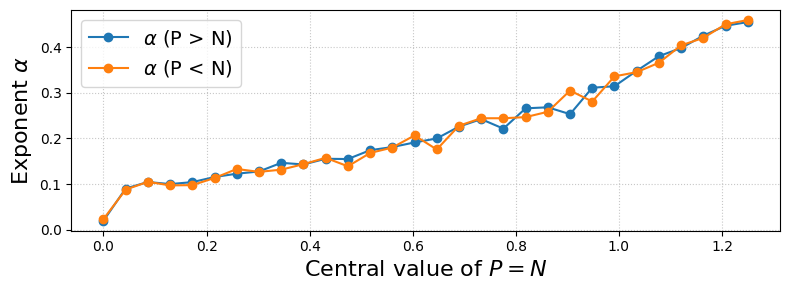

In [64]:
# --- Tracé des résultats ---
plt.figure(figsize=(8,3))
plt.plot(P_vals, alphas_pos, 'o-', label=r'$\alpha$ (P > N)', color='C0')
plt.plot(P_vals, alphas_neg, 'o-', label=r'$\alpha$ (P < N)', color='C1')



plt.xlabel(r'Central value of $P=N$', fontsize=16)
plt.ylabel(r'Exponent $\alpha$', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, ls=':', alpha=0.7)
plt.tight_layout()
plt.show()


The exponent $\alpha$ is an increasing function of $P = N$ (it appears to be linear), as expected, because the higher $P$ and $N$ are, the greater the inertia the system must overcome to converge toward either $a$ or $b$.


## 2. Asymmetrical system


$$
\frac{da}{dt} = P + \frac{\lambda_a \cdot a}{1 + k_a \cdot a} - \eta_a \cdot a - \mu_a \cdot a b
$$
$$
\frac{db}{dt} = N + \frac{\lambda_b \cdot b}{1 + k_b \cdot b} - \eta_b \cdot b - \mu_b \cdot a b
$$


### 1.2.1 Considering $\mu_a=\mu_b$ and $\eta_a=\eta_b$

In this section, we want to probe the effect of introducing asymmetry between $\alpha, \eta,\mu$ parameters for a and b, leading to a non N=P frontier.

First, as assumed in our computations, we take $\mu_a=\mu_b$ and $\eta_a=\eta_b$.


***(a) numerical solving***



Numerically, we aim to trace the boundary where $a^* = b^*$, that is, the equilibrium point where the two populations, $a$ and $b$, stabilize at equal levels (dynamic equilibrium).

Instead of using a *direct analytical formula* for $P = f(N)$, we solve the problem *numerically* by following these steps:

- 1 : Defining the Equilibrium Problem

We seek to find the *boundary* where $a^* = b^*$. For each value of $N$, we look for $P$ such that $a = b$ at the steady state.

- 2 : The Equation for $a^* = b^*$

For each value of $N$ in the interval $[0, N_{\text{max}}]$, the code searches for an *equilibrium point* where $a = b$. This is done by solving an equation of the form:

$$
a^*(P, N) = b^*(P, N)
$$

Thus, we look for $a^*$ such that $\dot{a} = \dot{b} = 0$. The code solves this condition using the *equation* based on the system dynamics, employing the function `steady_diff`.

The function `steady_diff(P, N)` computes the difference between $a$ and $b$ obtained after solving the system of differential equations:



In [65]:
# --- 1. Paramètres du modèle ---
eta_a, eta_b = 0.1, 0.1
mu_a,  mu_b  = 0.2, 0.2
k_a,   k_b   = 0.7,  0.3
lambda_a, lambda_b = 1.0, 1.0

# --- 2. Domaine d'étude ---
N_max, P_max = 2.0, 2.0

# grille pour integration + bruit
nb_of_points = 50
P_grid = np.linspace(0, P_max, nb_of_points)
N_grid = np.linspace(0, N_max, nb_of_points)
noise_sigma = 0.2

# conditions initiales et temps
y0      = [1e-6, 1e-6]
t_span  = (0, 100)

The decision boundary depends on dynamical constants, and by tuning $k_a$ and $k_b$, we can obtain nonlinear frontiers.


  0%|          | 0/2500 [00:00<?, ?it/s]

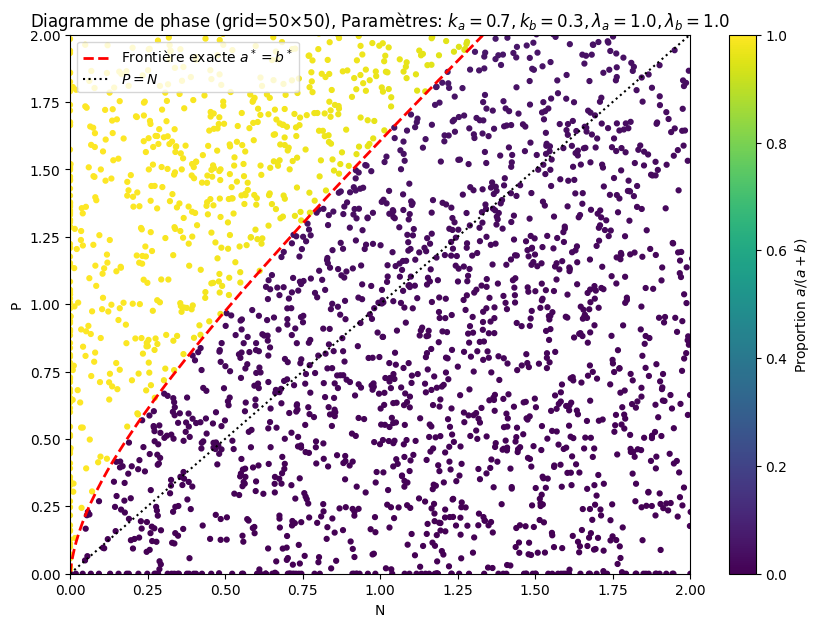

In [66]:
# --- Simulation ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_ode(P, N):
    """Renvoie (a*, b*) à la fin de l'intégration."""
    sol = solve_ivp(system, t_span, y0, args=(P, N),
                    dense_output=False, method='RK45',
                    rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- 4. Génération des données de simulation ---
results = []
for P0, N0 in tqdm(product(P_grid, N_grid),
                   total=nb_of_points**2):
    Pn = max(0, P0 + np.random.normal(scale=noise_sigma))
    Nn = max(0, N0 + np.random.normal(scale=noise_sigma))
    a_fin, b_fin = integrate_ode(Pn, Nn)
    results.append((Pn, Nn,
                    np.clip(a_fin, 0, 10),
                    np.clip(b_fin, 0, 10)))

results    = np.array(results)
P_plot     = results[:,0]
N_plot     = results[:,1]
a_low      = results[:,2]
b_low      = results[:,3]
a_fraction = a_low / (a_low + b_low + 1e-12)

# --- 5. Tracé du diagramme de phase ---
fig, ax = plt.subplots(figsize=(10,7))
sc = ax.scatter(N_plot, P_plot, c=a_fraction,
                cmap='viridis', s=12, marker='o')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Proportion $a/(a+b)$")

ax.set_xlabel("N")
ax.set_ylabel("P")
ax.set_title(
    f"Diagramme de phase (grid={nb_of_points}×{nb_of_points}), "
    f"Paramètres: $k_a={k_a},k_b={k_b},\\lambda_a={lambda_a},\\lambda_b={lambda_b}$"
)

# --- 6. Calcul et tracé de la frontière a* = b* par option 2 ---
frontier_N = []
frontier_P = []

# Balayage des N pour trouver P tel que a*(P,N) = b*(P,N)
def steady_diff(P, N):
    a_s, b_s = integrate_ode(P, N)
    return a_s - b_s

N_vals = np.linspace(0, N_max, 300)
for N in N_vals:
    try:
        sol = root_scalar(steady_diff, args=(N,),
                          bracket=[0, P_max], method='brentq', xtol=1e-3)
        if sol.converged:
            frontier_N.append(N)
            frontier_P.append(sol.root)
    except ValueError:
        # pas de racine dans [0,P_max]
        pass

ax.plot(frontier_N, frontier_P,
        linestyle='--', color='red', lw=2,
        label="Frontière exacte $a^*=b^*$")

# --- Ligne diagonale P = N ---
diag_max = min(P_max, N_max)
ax.plot([0, diag_max], [0, diag_max],
        linestyle=':', color='black', lw=1.5,
        label="$P=N$")

ax.set_xlim(0, N_max)
ax.set_ylim(0, P_max)
ax.legend()



We can also tune the initial concentrations $a_0$ and $b_0$ to shift the decision boundary.


In [67]:
# --- Parameters ---
eta_a = 0.1; eta_b = 0.1; mu_a = 0.2; mu_b = 0.2
k_a = 0.7; k_b = 0.7; lambda_a = 1.0; lambda_b = 1.0
alpha_bias = 4; beta_bias = 1e-6

# Grid limits and resolution
xlimit, ylimit = 1.25, 1.25
nb_points = 50
N_grid = np.linspace(0, xlimit, nb_points)

Computing boundary: 100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Polynomial boundary (degree 3): P(N) = -0.406*N**0 + 1.78*N**1 + -0.584*N**2 + 0.163*N**3


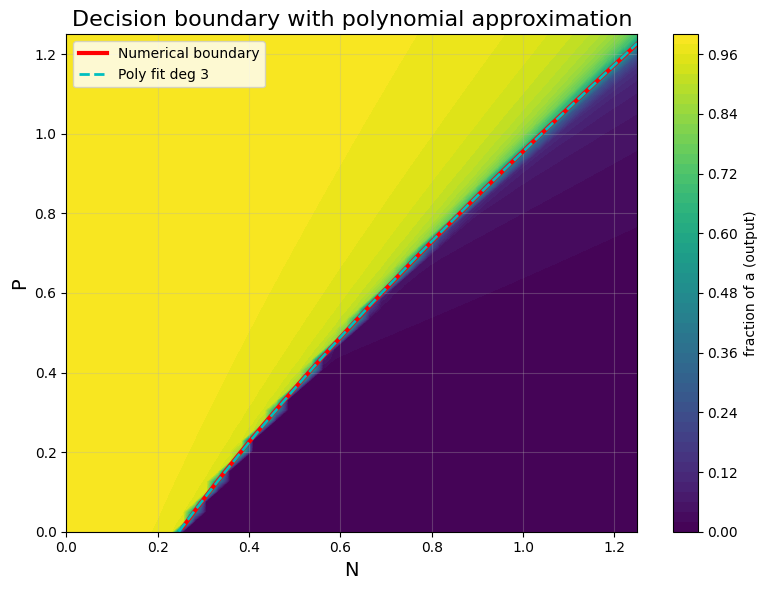

In [46]:
# --- Simlation ---

# Dynamic system definitions
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

def integrate_fraction(P, N, y0, t_span):
    t_eval = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(system, t_span, y0, args=(P, N), t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    a_final, b_final = sol.y[0, -1], sol.y[1, -1]
    return a_final / (a_final + b_final + 1e-10)

# Initial conditions and time span
y0 = [alpha_bias, beta_bias]
t_span = (0, 150)

# Bisection search for decision boundary P(N)
def find_P_for_N(N, P_min=0.0, P_max=ylimit, tol=1e-3, max_iter=30):
    f_min = integrate_fraction(P_min, N, y0, t_span) - 0.5
    f_max = integrate_fraction(P_max, N, y0, t_span) - 0.5
    if f_min * f_max > 0:
        return np.nan
    for _ in range(max_iter):
        P_mid = (P_min + P_max) / 2
        f_mid = integrate_fraction(P_mid, N, y0, t_span) - 0.5
        if abs(f_mid) < tol:
            return P_mid
        if f_min * f_mid < 0:
            P_max, f_max = P_mid, f_mid
        else:
            P_min, f_min = P_mid, f_mid
    return (P_min + P_max) / 2

# Compute boundary curve
P_boundary = np.array([find_P_for_N(N) for N in tqdm(N_grid, desc='Computing boundary')])

# Fit a polynomial to the boundary
# Choose degree based on expected non-linearity
degree = 3
valid = ~np.isnan(P_boundary)
coeffs = np.polyfit(N_grid[valid], P_boundary[valid], degree)
poly = np.poly1d(coeffs)
print(f"Polynomial boundary (degree {degree}): P(N) = {' + '.join(f'{coeff:.3g}*N**{i}' for i, coeff in enumerate(coeffs[::-1]))}")

# Plot
plt.figure(figsize=(8, 6))
# Contour background
grid_P, grid_N = np.meshgrid(np.linspace(0, ylimit, nb_points), N_grid)
frac_grid = np.array([[integrate_fraction(P_val, N_val, y0, t_span) 
                        for P_val, N_val in zip(P_row, N_row)] 
                       for P_row, N_row in zip(grid_P, grid_N)])
plt.contourf(grid_N, grid_P, frac_grid, levels=50, cmap='viridis')
plt.colorbar(label='fraction of a (output)')
# Numerical boundary
plt.plot(N_grid, P_boundary, 'r-', linewidth=3, label='Numerical boundary')
# Polynomial fit
N_line = np.linspace(0, xlimit, 200)
plt.plot(N_line, poly(N_line), 'c--', linewidth=2, label=f'Poly fit deg {degree}')

plt.xlabel('N', fontsize=14)
plt.ylabel('P', fontsize=14)
plt.title('Decision boundary with polynomial approximation', fontsize=16)
plt.legend()
plt.xlim(0, xlimit)
plt.ylim(0, ylimit)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The frontier can be approximated by a polynomial of degree 3 (wich can be approximated by a linear fonction), which captures the non-linear relationship between P and N. The polynomial fit provides a smooth approximation to the decision boundary, allowing for easier analysis and visualization of the system's behavior across the parameter space. Such a classification is easily tunable and very robust.

**Annexe : semi-analytical solving (not working)**

As one want the fixed point equation for $(a^*,b^*)$ then $\dot{x}=0$. So as to recover the frontier, the previous equation must satisfy $a^*=b^*$. This yelds to the frontier equation i.e. {$(P,N)/a^*=b^*$ according to the fp equation}
$$P=N+(\frac{\lambda_b}{1+k_b a^*}-\frac{\lambda_a}{1+k_a a^*})a^*$$


  0%|          | 0/900 [00:00<?, ?it/s]

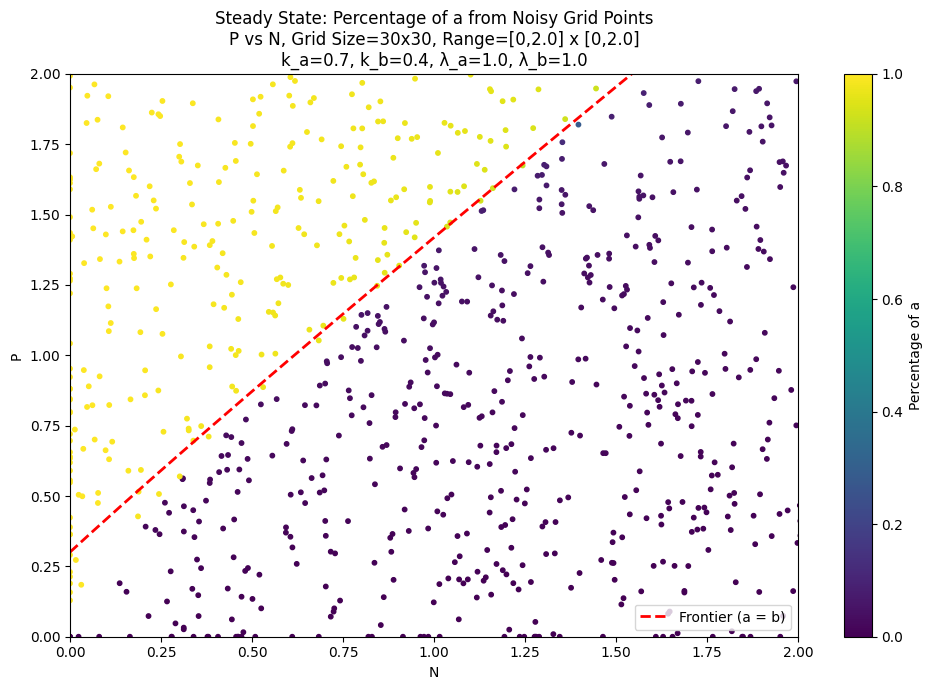

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm
from itertools import product

# --- Parameters ---
eta_a = 0.1
eta_b = 0.1
mu_a = 0.2
mu_b = 0.2

k_a = 0.7
k_b = 0.4
lambda_a = 1.0
lambda_b = 1.0

# --- Display range ---
N_max = 2.0
P_max = 2.0

# --- Parameter grid for numerical integration ---
nb_of_points = 30
P_grid = np.linspace(0.0, P_max, nb_of_points)
N_grid = np.linspace(0.0, N_max, nb_of_points)

# Noise parameters
noise_sigma = 0.2

# Time span and initial condition
t_span_full = (0, 100)
y0 = [1e-6, 1e-6]

# --- System equations ---
def da_dt(a, b, P):
    return P + (lambda_a * a) / (1 + k_a * a) - eta_a * a - mu_a * a * b

def db_dt(a, b, N):
    return N + (lambda_b * b) / (1 + k_b * b) - eta_b * b - mu_b * a * b

def system(t, y, P, N):
    a, b = y
    return [da_dt(a, b, P), db_dt(a, b, N)]

# --- Integration ---
def integrate_ode(P, N, y0, t_span, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 2000)
    sol = solve_ivp(system, t_span, y0,
                    args=(P, N),
                    t_eval=t_eval,
                    method='RK45', rtol=1e-8, atol=1e-10)
    return sol.y[0, -1], sol.y[1, -1]

# --- Generate simulation data ---
results = []
for P, N in tqdm(product(P_grid, N_grid), total=nb_of_points * nb_of_points):
    noisy_P = max(0.0, P + np.random.normal(loc=0, scale=noise_sigma))
    noisy_N = max(0.0, N + np.random.normal(loc=0, scale=noise_sigma))

    a_final, b_final = integrate_ode(noisy_P, noisy_N, y0, t_span_full)
    results.append((noisy_P, noisy_N, np.clip(a_final, 0, 10), np.clip(b_final, 0, 10)))

results = np.array(results)
P_plot = results[:, 0]
N_plot = results[:, 1]
a_low_plot = results[:, 2]
b_low_plot = results[:, 3]

# --- Plot phase diagram ---
fig, ax = plt.subplots(figsize=(10, 7))

a_percentage = a_low_plot / (a_low_plot + b_low_plot + 1e-10)

title = (
    f"Steady State: Percentage of a from Noisy Grid Points\n"
    f"P vs N, Grid Size={nb_of_points}x{nb_of_points}, Range=[0,{P_max}] x [0,{N_max}]\n"
    f"k_a={k_a}, k_b={k_b}, λ_a={lambda_a}, λ_b={lambda_b}"
)

sc = ax.scatter(N_plot, P_plot, c=a_percentage, cmap='viridis', s=10, marker='o')
ax.set_title(title)
ax.set_xlabel("N")
ax.set_ylabel("P")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Percentage of a")

# --- Compute and plot frontier a = b numerically ---
frontier_N = []
frontier_P = []

N_vals = np.linspace(0.0, N_max, 500)

for N in N_vals:
    def fixed_point_eq(a):
        return N + (lambda_b * a) / (1 + k_b * a) - eta_b * a - mu_b * a**2

    try:
        sol = root_scalar(fixed_point_eq, bracket=(1e-8, 20.0), method='brentq')
        if sol.converged:
            a_star = sol.root
            P = - (lambda_a * a_star) / (1 + k_a * a_star) + eta_a * a_star + mu_a * a_star**2
            if 0 <= P <= P_max:
                frontier_N.append(N)
                frontier_P.append(P)
    except ValueError:
        continue  # no solution in bracket

ax.plot(frontier_N, frontier_P, color='red', linestyle='--', linewidth=2, label='Frontier (a = b)')

# Final plot setup
ax.set_xlim(0, N_max)
ax.set_ylim(0, P_max)
ax.legend()
plt.tight_layout()
plt.show()
